# Project 3 – CNN for Image Classification: Cats vs. Dogs

## Step 1: Problem Statement

In this project, I'll build and evaluate a Convolutional Neural Network (CNN) that can distinguish between images of cats and dogs.

The model will be trained using a labeled dataset containing cat and dog images, and it will be evaluated based on its ability to classify unseen images correctly.

---

## Step 2: Dataset Selection

Dataset chosen: "Cats and Dogs Image Classification" dataset from Kaggle, which has pre-labeled images of cats and dogs.


In [24]:
import sys
print(sys.executable)


c:\Users\Preston Brownlee\Desktop\CST-435\Streamlit-Multi-App\.venv311\Scripts\python.exe


In [25]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

target_data_path = "data"

os.makedirs(target_data_path, exist_ok=True)

api = KaggleApi()
api.authenticate()

api.dataset_download_files(
    "samuelcortinhas/cats-and-dogs-image-classification",
    path=target_data_path,
    unzip=True
)

print("Dataset downloaded to:", target_data_path)


Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification
Dataset downloaded to: data


## Step 3: Dataset Description

The Cats and Dogs Image Classification dataset contains over 1,000 labeled images of cats and dogs collected from Google Images.  
The objective of this dataset is to train a Convolutional Neural Network (CNN) that can distinguish between the two animals based on image features.

### Dataset Details
- Classes: 2 (Cats, Dogs)  
- Total Images: Over 1,000  
- Image Format: JPEG  
- Image Dimensions: Vary between approximately 100×100 pixels and 2000×1000 pixels  
- Duplicates: Removed to ensure dataset integrity  

### Task Objective
The CNN model will be trained to classify an input image as either a cat or a dog, using convolutional layers to get spatial features and pooling layers to reduce dimensionality. The goal is to achieve the highest possible accuracy on the test images.


### Algorithm (Pipeline Overview)
1. Download and unpack Kaggle dataset to Project3/data/.
2. Build tf.data pipelines with an 80/20 train/val split, normalize inputs and apply light augmentation to training batches.
3. Define a CNN: 3 conv blocks (Conv2D→ReLU→MaxPool) → Flatten → Dense(128, ReLU) → Dense(softmax).
4. Compile with Adam + categorical crossentropy + accuracy.
5. Train for up to 50 epochs with EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint(save_best_only=True).
6. Reload the best checkpoint; evaluate on held-out test set; plot accuracy/loss; compute classification report and confusion matrix.


## Step 4: Import Libraries

In [ ]:
# Step 4: Imports & environment
import os, sys, random
from pathlib import Path

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# Jupyter plotting
%matplotlib inline

# env report
print(f"Python: {sys.version.split()[0]}")
print(f"TensorFlow: {tf.__version__}")
print("Kernel:", sys.executable)
print("GPUs:", tf.config.list_physical_devices("GPU"))

# Paths
PROJECT_DIR = Path.cwd()    
DATA_DIR = PROJECT_DIR / "data"
print("Data directory:", DATA_DIR.resolve())

layers     = tf.keras.layers
models     = tf.keras.models
callbacks  = tf.keras.callbacks
optimizers = tf.keras.optimizers


Python: 3.11.0
TensorFlow: 2.20.0
Kernel: c:\Users\Preston Brownlee\Desktop\CST-435\Streamlit-Multi-App\.venv311\Scripts\python.exe
GPUs: []
Data directory: C:\Users\Preston Brownlee\Desktop\CST-435\Streamlit-Multi-App\Project3\data


## Step 5: Initialize the CNN (First Convolutional Layer)

Here we create a Sequential model and add the first Conv2D layer with the required arguments:

- filters: 32  
- kernel_size: (3, 3)  
- padding: "same" (keeps spatial size)  
- activation: "relu"  
- input_shape: (H, W, C) = (IMG_SIZE[0], IMG_SIZE[1], 3)

This layer learns local spatial features using 3×3 kernels and ReLU non-linearity.


## Step 6: Apply Pooling to Downsample

We apply MaxPooling2D(pool_size=(2, 2), strides=2) after the first convolution. This reduces the spatial resolution by 2×, decreases computation, and helps the model focus on salient features rather than precise pixel locations.


## Step 7: Pooling Type and Rationale

Type used: Max pooling (MaxPooling2D).

Why max pooling?
- Preserves the strongest activation in each window (keeps the most discriminative features).
- Adds translation invariance (robust to small shifts).
- Reduces overfitting risk and compute compared to keeping full-resolution features.
- We prefer it in early layers over average/global pooling, which either smooths or discards spatial structure too aggressively early on.


## Step 8: Add Two Additional Convolutional Layers

We repeat Conv -> ReLU -> MaxPool twice more, increasing the number of filters to capture richer features at lower spatial resolutions.


In [32]:
IMG_SIZE = (160, 160)
BATCH    = 32

from pathlib import Path
train_dir = (Path.cwd() / "data" / "train")

if train_dir.exists():
    class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
    num_classes = len(class_names) if class_names else 2
else:
    class_names = ["cat", "dog"]
    num_classes = 2

print("Classes:", class_names)
print("num_classes:", num_classes)


Classes: ['cats', 'dogs']
num_classes: 2


In [33]:
import tensorflow as tf

IMG_SIZE = globals().get("IMG_SIZE", (160, 160))
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)

model = tf.keras.models.Sequential(name="CatsDogs_CNN")

model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    activation="relu",
    input_shape=input_shape,
    name="conv1"
))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="pool1"))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu", name="conv2"))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2, name="pool2"))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu", name="conv3"))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2, name="pool3"))

model.summary()



Model: "CatsDogs_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 20, 20, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

## Step 9 & 10: Flatten -> Dense(ReLU) -> Dense(Softmax)

In [34]:
import tensorflow as tf
from pathlib import Path

train_dir = Path.cwd() / "data" / "train"
if train_dir.exists():
    class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
    num_classes = len(class_names) if class_names else 2
else:
    class_names = ["cats", "dogs"]
    num_classes = 2

has_flatten = any(isinstance(l, tf.keras.layers.Flatten) for l in model.layers)
if not has_flatten:
    model.add(tf.keras.layers.Flatten(name="flatten"))
    model.add(tf.keras.layers.Dense(128, activation="relu", name="fc1"))
    model.add(tf.keras.layers.Dropout(0.3, name="dropout")) 
    model.add(tf.keras.layers.Dense(num_classes, activation="softmax", name="predictions"))

model.summary()
print("Classes:", class_names, "| num_classes:", num_classes)


Model: "CatsDogs_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,234 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

Classes: ['cats', 'dogs'] | num_classes: 2


## Step 11: Compile, Train, Evaluate, Plot

In [ ]:
import tensorflow as tf
from pathlib import Path

SEED     = globals().get("SEED", 42)
IMG_SIZE = globals().get("IMG_SIZE", (160, 160))
BATCH    = globals().get("BATCH", 32)

DATA_DIR = Path.cwd() / "data"
train_dir = DATA_DIR / "train"
test_dir  = DATA_DIR / "test"

assert train_dir.exists(), f"Missing folder: {train_dir}"
assert test_dir.exists(),  f"Missing folder: {test_dir}"

raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.20,
    subset="training",
    seed=SEED,
    shuffle=True,
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=0.20,
    subset="validation",
    seed=SEED,
    shuffle=False,
)

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical", 
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False,
    seed=SEED,
)

if getattr(raw_test_ds, "class_names", None) is None:
    raw_test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels="inferred",
        label_mode="categorical",
        image_size=IMG_SIZE,
        batch_size=BATCH,
        shuffle=False,
    )

class_names = raw_train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names, "| num_classes:", num_classes)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
], name="augment")

normalizer = tf.keras.layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

def prep(ds, training=False):
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (normalizer(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prep(raw_train_ds, training=True)
val_ds   = prep(raw_val_ds,   training=False)
test_ds  = prep(raw_test_ds,  training=False)

if "model" not in globals() or model is None:
    print("Rebuilding model because it was not found in memory.")
    model = tf.keras.models.Sequential(name="CatsDogs_CNN")
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu",
                                     input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name="conv1"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2, name="pool1"))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu", name="conv2"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2, name="pool2"))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu", name="conv3"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2, name="pool3"))
    model.add(tf.keras.layers.Flatten(name="flatten"))
    model.add(tf.keras.layers.Dense(128, activation="relu", name="fc1"))
    model.add(tf.keras.layers.Dropout(0.3, name="dropout"))
    model.add(tf.keras.layers.Dense(num_classes, activation="softmax", name="predictions"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
print("Model compiled.")


Found 557 files belonging to 2 classes.
Using 446 files for training.
Found 557 files belonging to 2 classes.
Using 111 files for validation.
Found 140 files belonging to 2 classes.
Classes: ['cats', 'dogs'] | num_classes: 2
Model compiled.


In [ ]:
import tensorflow as tf
from pathlib import Path

OUT_DIR = Path.cwd()
MODEL_F = OUT_DIR / "model_catsdogs.keras"
print("Will save best model to:", MODEL_F)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(MODEL_F),
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1  
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,                      
    callbacks=[ckpt, early, plateau]
)

print("Training done. File exists?", MODEL_F.exists(), "| size (MB):",
      round(MODEL_F.stat().st_size/1e6, 2) if MODEL_F.exists() else "—")


Will save best model to: c:\Users\Preston Brownlee\Desktop\CST-435\Streamlit-Multi-App\Project3\model_catsdogs.keras
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5160 - loss: 0.7412
Epoch 1: val_accuracy improved from None to 0.60360, saving model to c:\Users\Preston Brownlee\Desktop\CST-435\Streamlit-Multi-App\Project3\model_catsdogs.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.5045 - loss: 0.7133 - val_accuracy: 0.6036 - val_loss: 0.6394 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6314 - loss: 0.6760
Epoch 2: val_accuracy improved from 0.60360 to 0.69369, saving model to c:\Users\Preston Brownlee\Desktop\CST-435\Streamlit-Multi-App\Project3\model_catsdogs.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.5919 - loss: 0.6778 - val_accuracy: 0.6937 - val_loss: 0.5945 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5693 - loss: 0.6672
Epoch 3: val_accur

In-RAM   -> Test acc: 0.7071 | loss: 0.8062
Reloaded -> Test acc: 0.6643 | loss: 0.7075


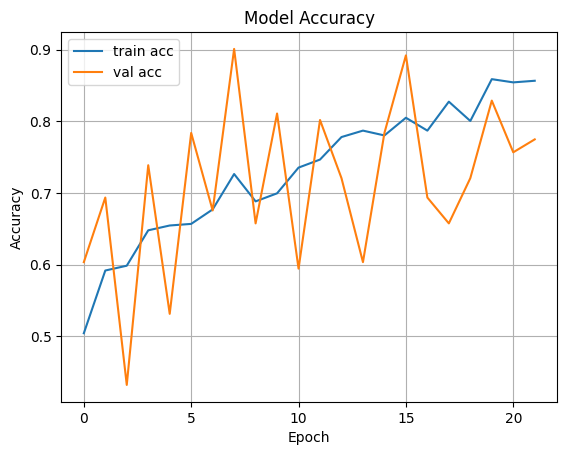

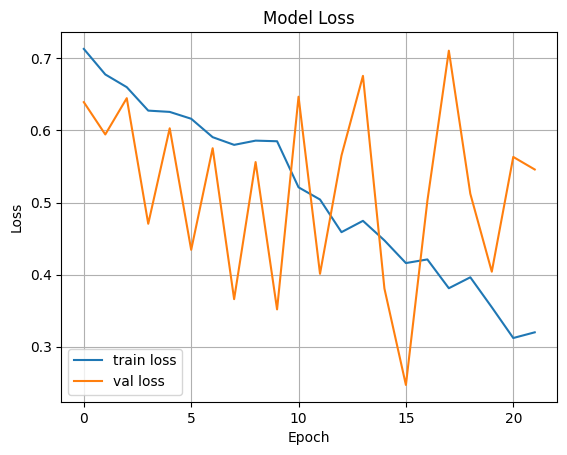


Classification report:

              precision    recall  f1-score   support

        cats     0.8108    0.4286    0.5607        70
        dogs     0.6117    0.9000    0.7283        70

    accuracy                         0.6643       140
   macro avg     0.7112    0.6643    0.6445       140
weighted avg     0.7112    0.6643    0.6445       140



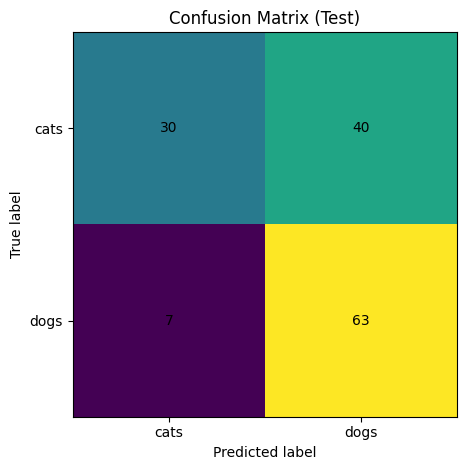

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

MODEL_F = Path.cwd() / "model_catsdogs.keras"
loaded = tf.keras.models.load_model(MODEL_F)

ram_loss,   ram_acc   = model.evaluate(test_ds,  verbose=0)
disk_loss,  disk_acc  = loaded.evaluate(test_ds, verbose=0)
print(f"In-RAM   -> Test acc: {ram_acc:.4f} | loss: {ram_loss:.4f}")
print(f"Reloaded -> Test acc: {disk_acc:.4f} | loss: {disk_loss:.4f}")

# Plot accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.title("Model Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True); plt.show()

# Plot loss
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("Model Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

try:
    from sklearn.metrics import confusion_matrix, classification_report
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    from sklearn.metrics import confusion_matrix, classification_report

# Collect labels/preds from test_ds
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    probs = loaded.predict(x_batch, verbose=0)
    y_pred.append(np.argmax(probs, axis=1))
    y_true.append(np.argmax(y_batch.numpy(), axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.xticks(range(len(class_names)), class_names)
plt.yticks(range(len(class_names)), class_names)
plt.ylabel("True label"); plt.xlabel("Predicted label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


In [ ]:
from pathlib import Path
import json

OUT_DIR = Path.cwd()
NAMES_F = OUT_DIR / "class_names.txt"
HIST_F  = OUT_DIR / "history.json"

with open(NAMES_F, "w") as f:
    for n in class_names:
        f.write(n + "\n")
print(f"Saved class names -> {NAMES_F}")

if history is not None and hasattr(history, "history"):
    with open(HIST_F, "w") as f:
        json.dump(history.history, f)
    print(f"Saved training history -> {HIST_F}")


Saved class names -> c:\Users\Preston Brownlee\Desktop\CST-435\Streamlit-Multi-App\Project3\class_names.txt
Saved training history -> c:\Users\Preston Brownlee\Desktop\CST-435\Streamlit-Multi-App\Project3\history.json


In [40]:
from pathlib import Path
for p in ["model_catsdogs.keras", "class_names.txt", "history.json"]:
    q = Path.cwd() / p
    print(f"{p:22} exists? {q.exists()}  size:", (q.stat().st_size if q.exists() else "—"))


model_catsdogs.keras   exists? True  size: 79814234
class_names.txt        exists? True  size: 12
history.json           exists? True  size: 2345


## Step 12: Summary of Ability & Performance

Task. Train a CNN to classify images as cats vs dogs.

Architecture. 3 × (Conv2D → ReLU → MaxPooling2D) → Flatten → Dense(128, ReLU) → Dense(Softmax).

Pooling choice. I used MaxPooling2D (2×2, stride 2) in each block to reduce spatial resolution, retain the strongest activations, and add translation invariance while keeping compute lower than operating at full resolution.

Training setup. Optimizer = Adam, Loss = categorical_crossentropy, Metric = accuracy, Epochs = 50 (with EarlyStopping + ReduceLROnPlateau + ModelCheckpoint). Train/Val split = 80/20 from the training set; a held-out test set (data/test) is used for final evaluation.

Results (this run).
- Best validation accuracy: 0.901 (epoch 8)
- Test accuracy (in RAM model): 0.707  
- Test accuracy (reloaded checkpoint): 0.664  
- See the accuracy/loss curves above for training dynamics.

Per-class report (test).
- cats — precision: 0.811, recall: 0.429, F1: 0.561  
- dogs — precision: 0.612, recall: 0.900, F1: 0.728  
- Confusion matrix is shown above.

Analysis.  
- The model clearly learned useful features, but shows a recall gap: it’s conservative about calling “cat” (high false negatives for cats). This may stem from small data, image quality variance, or augmentation strength.  
- The val best (≈0.90) vs test (≈0.66–0.71) gap suggests either a slightly easier validation split or some domain shift in the test set.

References.
- Kaggle dataset: Cats and Dogs Image Classification (Samuel Cortinhas).
